


<h2 align="center">Simplilearn Certification Programs - Deep Learning with Keras and Tensorflow</h2>  

<div style="font-size:20px;">
<br/><b> <center> Project Report - Lending Club Loan Data Analysis</center></b><br/>
</div>

<div  style="font-size: 15px">
Organization: <b>Simplilearn (Certification Program)</b><br>
Course: <b>Deep Learning with Keras and Tensorflow</b><br>
Project: <b>Lending Club Loan Data Analysis</b><br>
Programming Language: <b>Python</b><br>
Submitted by: <b>Lavkush Singh</b>
</div>

## Problem Statement

**In this project, using the historical data from 2007 to 2015, you have to build a deep learning model to predict the chance of default for future loans.**

##### Analysis Tasks to be performed

1. Feature Transformation
        - Transform categorical values into numerical values (discrete)

2. Exploratory data analysis of different factors of the dataset.


3. Additional Feature Engineering
        - You will check the correlation between features and will drop those features which have a strong correlation
        - This will help reduce the number of features and will leave you with the most relevant features

4. Modeling
        - After applying EDA and feature engineering, you are now ready to build the predictive models
        - In this part, you will create a deep learning model using Keras with Tensorflow backend

In [1]:
# importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from plot_metric.functions import BinaryClassification
import keras_tuner as kt

In [2]:
# setting options to display for jupyter notebook
pd.options.display.max_rows = None

### Task: Load the dataset 

In [3]:
data_main = pd.read_csv("Datasets/loan_data.csv", low_memory = False)

In [4]:
df = data_main.copy(deep = True) # creating the copy to keep the original data intact

#### Exploring the dataset

In [5]:
df.head() 

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [7]:
df['not.fully.paid'].isnull().any() # checking if the 'not.fully.paid' (target) column has null values

False

In [8]:
df['not.fully.paid'].value_counts()

0    8045
1    1533
Name: not.fully.paid, dtype: int64

<div style="font-size: 16px;color:blue"> <b>Analysis Summary: </b></div><br/>

<div  style="font-size:15px;color:blue">
- The dataset contains total 14 columns (including target) with 9578 observations.<br/>
- This is a supervised binary (0,1) classification problem.<br/>
- The dataset is imbalanced, with more of '0' class.<br/>
</div>

#### Validation and Handling of the NULL and Duplicate Values

In [9]:
# custom function which takes dataframe as input and returns a dataframe of null values column wise, along with percentage

def create_nulls_df(dataframe):
    nulls_count = dataframe.isna().sum()[dataframe.isnull().sum() > 0]
    nulls_info_df = pd.DataFrame({'column':nulls_count.index, 
                                  'null_values': nulls_count.values}).sort_values(by=['null_values'])
    nulls_info_df['nulls_percent'] = ((nulls_info_df['null_values']/df.shape[0])*100).round(2)

    return nulls_info_df

In [10]:
nulls_info_df = create_nulls_df(dataframe=df)
nulls_info_df

,column,null_values,nulls_percent


In [11]:
df.duplicated().sum() # checking if the dataset has duplicate values

0

### Task: Exploratory data analysis of different factors of the dataset.

In [12]:
# custom function which takes dataframe as input and returns the unique values in each column, along with count in dict format

def unique_value_and_counts(dataframe):
    result = dict()
    for col in dataframe.columns:
        unique_counts = ('UNIQUE_COUNTS', dataframe[col].nunique())
        value = list(zip(dataframe[col].value_counts().index, dataframe[col].value_counts()))
        value.insert(0, unique_counts)
        result[col] = value
    return result     

In [13]:
df.columns

Index(['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
       'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid'],
      dtype='object')

In [14]:
# getting the unique values in each column along with the count 
# (dataframe passed here is having column values as discrete)

temp = unique_value_and_counts(df[['purpose','credit.policy','inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid']])
temp

{'purpose': [('UNIQUE_COUNTS', 7),
  ('debt_consolidation', 3957),
  ('all_other', 2331),
  ('credit_card', 1262),
  ('home_improvement', 629),
  ('small_business', 619),
  ('major_purchase', 437),
  ('educational', 343)],
 'credit.policy': [('UNIQUE_COUNTS', 2), (1, 7710), (0, 1868)],
 'inq.last.6mths': [('UNIQUE_COUNTS', 28),
  (0, 3637),
  (1, 2462),
  (2, 1384),
  (3, 864),
  (4, 475),
  (5, 278),
  (6, 165),
  (7, 100),
  (8, 72),
  (9, 47),
  (10, 23),
  (11, 15),
  (12, 15),
  (15, 9),
  (13, 6),
  (14, 6),
  (18, 4),
  (16, 3),
  (24, 2),
  (19, 2),
  (17, 2),
  (27, 1),
  (28, 1),
  (25, 1),
  (32, 1),
  (20, 1),
  (33, 1),
  (31, 1)],
 'delinq.2yrs': [('UNIQUE_COUNTS', 11),
  (0, 8458),
  (1, 832),
  (2, 192),
  (3, 65),
  (4, 19),
  (5, 6),
  (6, 2),
  (7, 1),
  (13, 1),
  (11, 1),
  (8, 1)],
 'pub.rec': [('UNIQUE_COUNTS', 6),
  (0, 9019),
  (1, 533),
  (2, 19),
  (3, 5),
  (5, 1),
  (4, 1)],
 'not.fully.paid': [('UNIQUE_COUNTS', 2), (0, 8045), (1, 1533)]}

In [15]:
temp['purpose'] 

[('UNIQUE_COUNTS', 7),
 ('debt_consolidation', 3957),
 ('all_other', 2331),
 ('credit_card', 1262),
 ('home_improvement', 629),
 ('small_business', 619),
 ('major_purchase', 437),
 ('educational', 343)]

In [16]:
purpose_index = [tup[0] for tup in temp['purpose'][1:]]  # getting index values of 'purpose' column to plot
print(purpose_index)

['debt_consolidation', 'all_other', 'credit_card', 'home_improvement', 'small_business', 'major_purchase', 'educational']


In [17]:
purpose_values = [tup[1] for tup in temp['purpose'][1:]] # getting values of 'purpose' column to plot
print(purpose_values)

[3957, 2331, 1262, 629, 619, 437, 343]


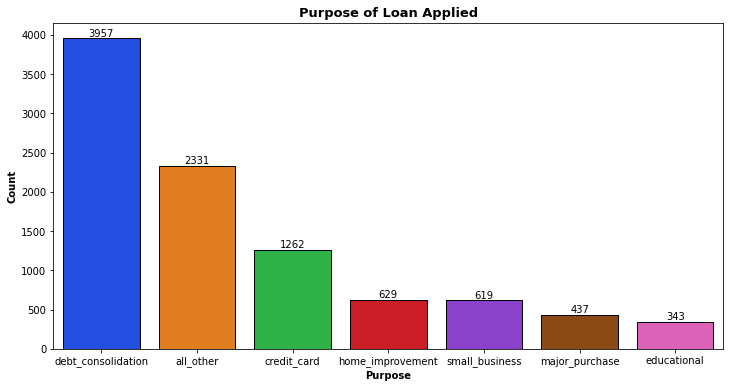

In [18]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x = purpose_index, y = purpose_values, palette = "bright", edgecolor='black')
ax.bar_label(ax.containers[0])
plt.title('Purpose of Loan Applied', fontsize = 13, fontweight="bold")
plt.xlabel('Purpose', fontweight="bold")
plt.ylabel('Count', fontweight="bold");

### Task: Transform categorical values into numerical values (discrete)

In [19]:
df_encoded = pd.get_dummies(df, drop_first = True)
df_encoded.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


In [20]:
df_encoded.shape

(9578, 19)

In [21]:
credit_policy_status = df['credit.policy'].value_counts()
credit_policy_status

1    7710
0    1868
Name: credit.policy, dtype: int64

#### Plotting column 'credit.policy' as pie chart

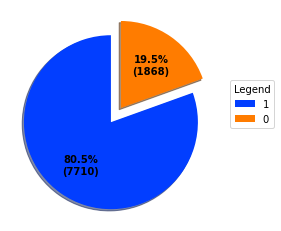

In [22]:
fig, ax = plt.subplots(figsize=[12,4])

labels = credit_policy_status.index
data = credit_policy_status.values
title = "Credit Status Distribution"
colors = sns.color_palette('bright')[0:10]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute})"

wedges, texts, autopcts = ax.pie(x= data, 
                                 autopct=lambda pct: func(pct, data), 
                                 explode=[0.1]*len(data), 
                                 shadow=True, 
                                 startangle = 90,
                                 colors = colors,
                                 radius=1
                                 )
# Adding legend
ax.legend(wedges, labels,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0.5, 1, 0.1))

plt.setp(autopcts, **{'color':'black', 'weight':'bold', 'fontsize':10});

#### Visualizing the numerical type columns distribution

In [23]:
# setting column names into variables as list to visualize KDE Plot using subplots

set_1 = ['int.rate', 'installment', 'log.annual.inc', 'dti']
set_2 = ['fico', 'days.with.cr.line', 'revol.bal', 'revol.util']

In [24]:
# converting columns into array to traverse through it and plotting graph as sub-plots

arr_cols = np.array(set_1).reshape(2,2)
arr_cols

array([['int.rate', 'installment'],
       ['log.annual.inc', 'dti']], dtype='<U14')

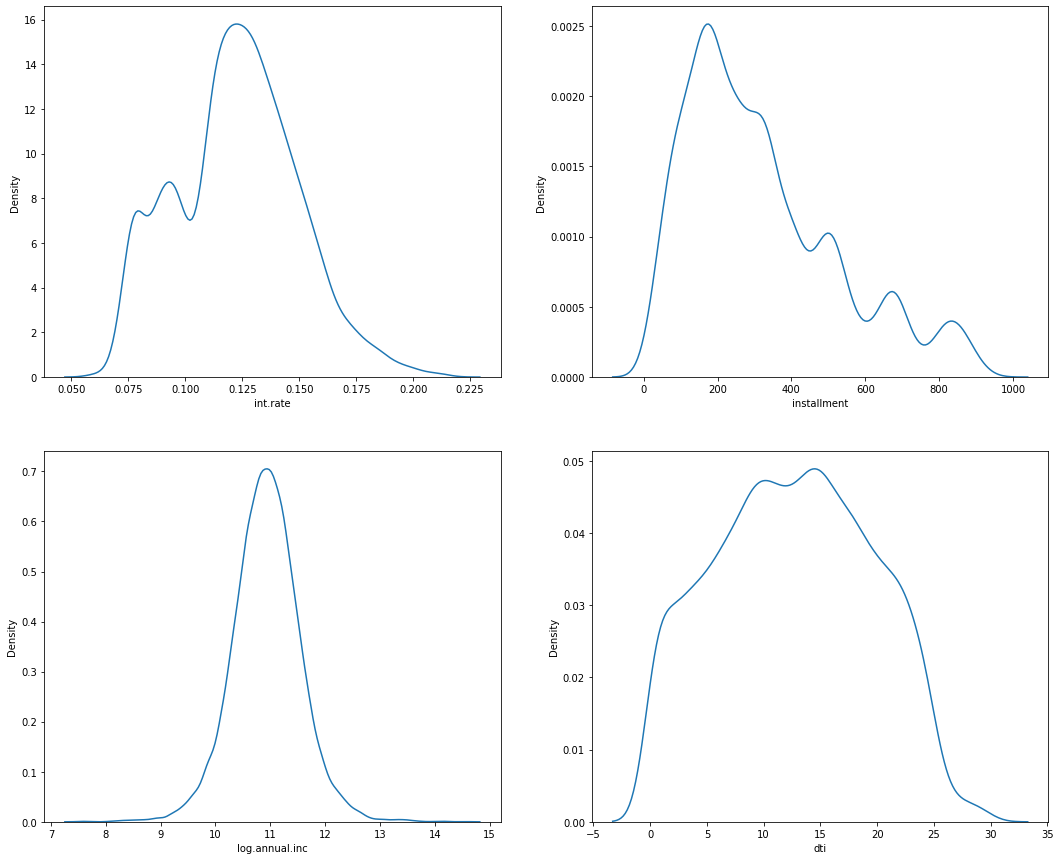

In [25]:
# plotting KDE plot to view how the data is distributed

fig, axes = plt.subplots(2, 2, figsize=(18, 15))

for i in range(2):
    for j in range(2):
            sns.kdeplot(ax=axes[i, j], data = df, x = arr_cols[i,j])

In [26]:
# converting second set of columns into array to traverse through it and plotting graph as sub-plots

arr_cols = np.array(set_2).reshape(2,2)
arr_cols

array([['fico', 'days.with.cr.line'],
       ['revol.bal', 'revol.util']], dtype='<U17')

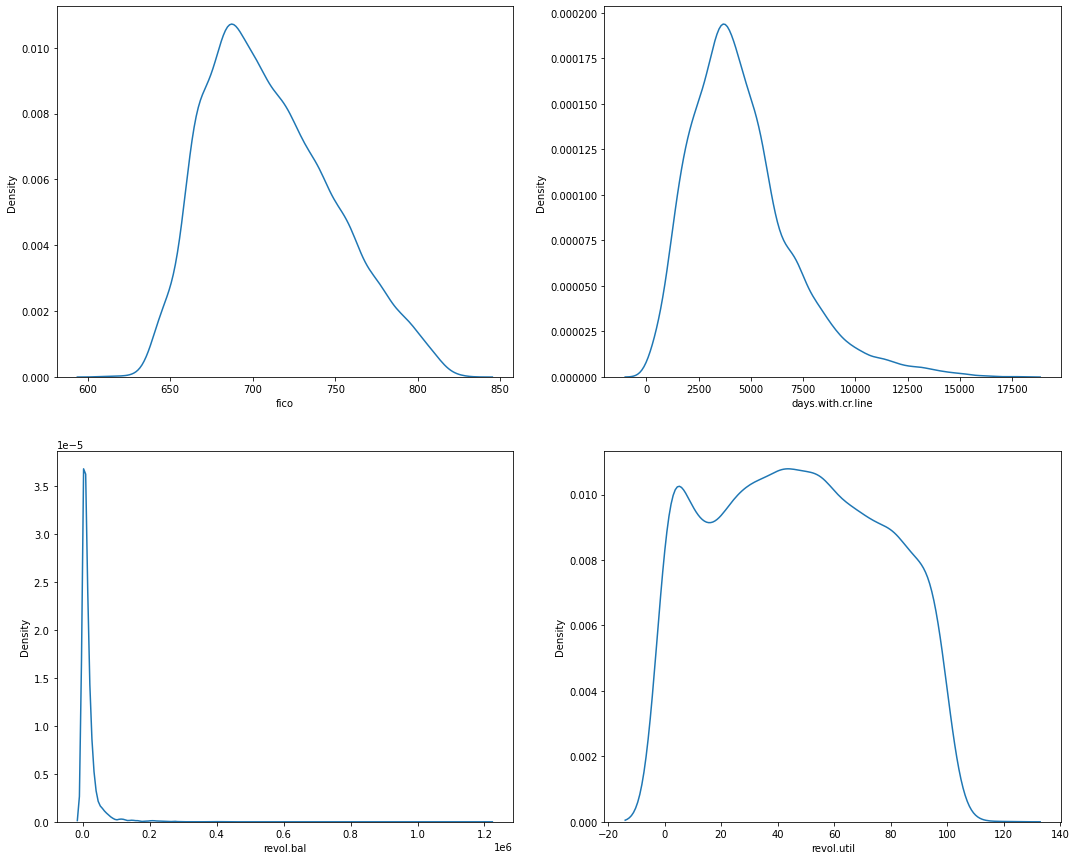

In [27]:
# plotting KDE plot to view how the data is distributed

fig, axes = plt.subplots(2, 2, figsize=(18, 15))

for i in range(2):
    for j in range(2):
            sns.kdeplot(ax=axes[i, j], data = df, x = arr_cols[i,j])

<div style="font-size: 16px;color:blue"> <b>Analysis Summary: </b></div><br/>

<div  style="font-size:15px;color:blue">
- The dataset does not have any null or duplicate values.<br/>
- The purpose column reveals that most of the loan applied is for 'debt_consolidation', where as 'educational' purpose loan is very less frequent<br/>
- About 80.5% customers of the given dataset meets the credit underwriting criteria of LendingClub.com.<br/>
- Numerical columns have been plotted as KDE plot and they follow uneven distribution. Refer graphs above. <br/>
</div>

### Task: Print percentage of default to payer of the dataset for the TARGET column

In [28]:
target_dist = df["not.fully.paid"].value_counts()
target_dist

0    8045
1    1533
Name: not.fully.paid, dtype: int64

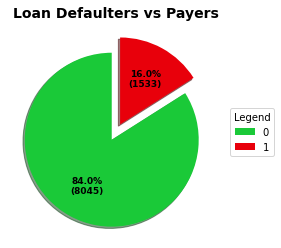

In [29]:
fig, ax = plt.subplots(figsize=[12,4])

labels = target_dist.index
data = target_dist.values
title = "Loan Defaulters vs Payers"
colors = sns.color_palette('bright')[2:4]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

wedges, texts, autopcts = ax.pie(x= data, 
                                 autopct=lambda pct: func(pct, data), 
                                 explode=[0.1]*len(data), 
                                 shadow=True, 
                                 startangle = 90,
                                 colors = colors
                                 )
# Adding legend
ax.legend(wedges, labels,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autopcts, **{'color':'black', 'weight':'bold', 'fontsize':9})
plt.title(title, fontsize=14, fontweight="bold");


### Task: Correlation Analysis and Feature reduction

In [30]:
# This below function calculates the Variance Inflation Factor, which basically tells us if the numerical column present in 
# our data is adding to the value or not.

def get_VIF(input_df):
    
    cols = input_df.columns
    
    for col in cols:
        X = input_df.drop(col, axis = 1)
        y = input_df[col]
        
        r_sq = ols(formula = 'y ~ X', data = input_df).fit().rsquared
        vif = round( 1/(1-r_sq),2)
        print(f"{col} VIF: {vif}")

In [31]:
set_1 + set_2

['int.rate',
 'installment',
 'log.annual.inc',
 'dti',
 'fico',
 'days.with.cr.line',
 'revol.bal',
 'revol.util']

In [32]:
get_VIF(df[set_1 + set_2])

int.rate VIF: 2.69
installment VIF: 1.59
log.annual.inc VIF: 1.51
dti VIF: 1.19
fico VIF: 2.97
days.with.cr.line VIF: 1.24
revol.bal VIF: 1.27
revol.util VIF: 1.6


In [33]:
# getting correlation of the data columns with each other

corr = df_encoded.loc[:, :'pub.rec'].corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
credit.policy,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
int.rate,-0.29,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
installment,0.06,0.28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
log.annual.inc,0.03,0.06,0.45,nan,nan,nan,nan,nan,nan,nan,nan,nan
dti,-0.09,0.22,0.05,-0.05,nan,nan,nan,nan,nan,nan,nan,nan
fico,0.35,-0.71,0.09,0.11,-0.24,nan,nan,nan,nan,nan,nan,nan
days.with.cr.line,0.10,-0.12,0.18,0.34,0.06,0.26,nan,nan,nan,nan,nan,nan
revol.bal,-0.19,0.09,0.23,0.37,0.19,-0.02,0.23,nan,nan,nan,nan,nan
revol.util,-0.10,0.46,0.08,0.05,0.34,-0.54,-0.02,0.20,nan,nan,nan,nan
inq.last.6mths,-0.54,0.20,-0.01,0.03,0.03,-0.19,-0.04,0.02,-0.01,nan,nan,nan


In [34]:
# Instead of viewing the entire correlation matrix, if I am interested in specific correlation values, 
# this is how we will get it, along with the column names which are correlated.

for row in corr.columns:
    for col in corr.columns:
        if corr.loc[row, col] >= 0.5 or corr.loc[row, col] < -0.5:
            print(f"{row}    {col}: {corr.loc[row, col]}")

fico    int.rate: -0.7148207714193276
revol.util    fico: -0.5412893350075509
inq.last.6mths    credit.policy: -0.5355111793311784


In [35]:
df_encoded = df_encoded.drop(['fico', 'inq.last.6mths'], axis = 1)

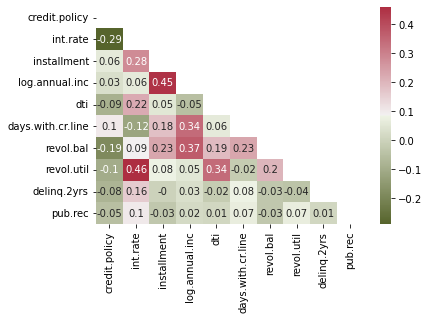

In [36]:
corr_data = df_encoded.loc[:, :'pub.rec'].corr().round(2)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(np.ones_like(corr_data))

# Create a custom divergin palette
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

# using the upper triangle matrix as mask 
sns.heatmap(corr_data, annot=True, mask=matrix, cmap=cmap);

<div style="font-size: 16px;color:blue"> <b>Analysis Summary: </b></div><br/>

<div  style="font-size:15px;color:blue">
- Validated the VIF (Variance Inflation Factor) of numerical columns, they were all less then 3.<br/>
- Correlation plot reveals that following columns were related:<br/><br/>
        <b>&emsp;&emsp;* fico & int.rate: -71.48% </b><br/>
        <b>&emsp;&emsp;* revol.util & fico: -54.13% </b><br/>
        <b>&emsp;&emsp;* inq.last.6mths & credit.policy: -53.55%  </b><br/><br/>
- Therefore, 'fico', 'inq.last.6mths' columns were dropped. <br/>
- Correlation heatmap was plotted again, and no correlation above 50% was observed.<br/>
</div>

### Task: Balance the dataset if the data is imbalanced

In [37]:
df_encoded.duplicated().sum() # checking if the processed data has not introduced duplicate values

0

In [38]:
df_encoded.columns

Index(['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'days.with.cr.line', 'revol.bal', 'revol.util', 'delinq.2yrs',
       'pub.rec', 'not.fully.paid', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_major_purchase',
       'purpose_small_business'],
      dtype='object')

#### Moving the target column 'not.fully.paid' at the end

In [39]:
column_to_move = df_encoded.pop('not.fully.paid')

In [40]:
df_encoded.insert(df_encoded.shape[1], "not.fully.paid", column_to_move)
df_encoded.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,days.with.cr.line,revol.bal,revol.util,delinq.2yrs,pub.rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,not.fully.paid
0,1,0.1189,829.10,11.350407,19.48,5639.958333,28854,52.1,0,0,0,1,0,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,2760.000000,33623,76.7,0,0,1,0,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,4710.000000,3511,25.6,0,0,0,1,0,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,2699.958333,33667,73.2,0,0,0,1,0,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,4066.000000,4740,39.5,1,0,1,0,0,0,0,0,0


In [41]:
df_encoded.shape # checking the shape of the dataset

(9578, 17)

In [42]:
X_cols = df_encoded.columns[:-1] # Storing feature names in a variable
print(X_cols)

Index(['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'days.with.cr.line', 'revol.bal', 'revol.util', 'delinq.2yrs',
       'pub.rec', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_small_business'],
      dtype='object')


#### Splitting of the dataset

In [44]:
# Splitting the dataset into X and y

X = df_encoded.drop('not.fully.paid', axis = 1).values
y = df_encoded['not.fully.paid'].values

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [46]:
X_train.shape, y_train.shape # checking shape of training data

((7183, 16), (7183,))

In [47]:
X_test.shape, y_test.shape # checking shape of test data

((2395, 16), (2395,))

In [48]:
# Getting training data classes distribution as series

train_target_dist = pd.Series(Counter(y_train))
train_target_dist

0    6016
1    1167
dtype: int64

In [49]:
# Getting test data classes distribution as series

test_target_dist = pd.Series(Counter(y_test))
test_target_dist

0    2029
1     366
dtype: int64

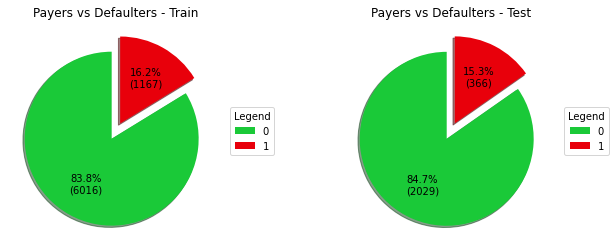

In [50]:
# plotting the pie charts to represent the distribution of target classes across training and test dataset

fig, (ax1, ax2) = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=[11,4])

labels_1 = train_target_dist.index
data_1 = train_target_dist.values
title_1 = "Payers vs Defaulters - Train"

labels_2 = test_target_dist.index
data_2 = test_target_dist.values
title_2 = "Payers vs Defaulters - Test"

colors = sns.color_palette('bright')[2:4]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

wedges_1, texts_1, autopcts_1 = ax1.pie(x= data_1, 
                                         autopct=lambda pct: func(pct, data_1), 
                                         explode=[0.1]*len(data_1), 
                                         shadow=True, 
                                         startangle = 90,
                                         colors = colors
                                         )

wedges_2, texts_2, autopcts_2 = ax2.pie(x= data_2, 
                                         autopct=lambda pct: func(pct, data_2), 
                                         explode=[0.1]*len(data_2), 
                                         shadow=True, 
                                         startangle = 90,
                                         colors = colors
                                         )

# Adding legend
ax1.legend(wedges_1, labels_1,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

ax2.legend(wedges_2, labels_2,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':9})

ax1.set_title(title_1, fontsize=12)
ax2.set_title(title_2, fontsize=12)
plt.show()

#### Balancing the dataset using Oversampling (RandomOverSampler)

In [51]:
oversampler = RandomOverSampler(sampling_strategy = 0.8, random_state= 101)

X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train,y_train)

print(f"The number of classes before fit {Counter(y_train)}")
print(f"The number of classes after fit {Counter(y_train_oversampled)}")

The number of classes before fit Counter({0: 6016, 1: 1167})
The number of classes after fit Counter({0: 6016, 1: 4812})


In [52]:
oversampler_smote = SMOTETomek(sampling_strategy = 0.8, n_jobs = -1, random_state=101)
X_train_oversampled_smote, y_train_oversampled_smote = oversampler_smote.fit_resample(X_train,y_train)

print(f"The number of classes before fit {Counter(y_train)}")
print(f"The number of classes after fit {Counter(y_train_oversampled_smote)}")

The number of classes before fit Counter({0: 6016, 1: 1167})
The number of classes after fit Counter({0: 5558, 1: 4354})


In [53]:
X_train.shape, y_train.shape

((7183, 16), (7183,))

In [54]:
X_train_oversampled.shape, y_train_oversampled.shape

((10828, 16), (10828,))

In [55]:
X_train_oversampled_smote.shape, y_train_oversampled_smote.shape

((9912, 16), (9912,))

In [56]:
before_oversampling_train_target = pd.Series(Counter(y_train))
after_oversampling_train_target = pd.Series(Counter(y_train_oversampled))
after_oversampling_smote_train_target = pd.Series(Counter(y_train_oversampled_smote))

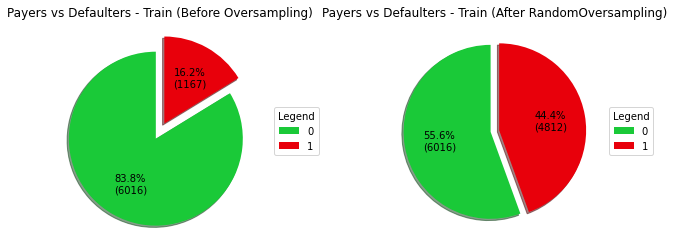

In [57]:
# Plotting the target classes distribution before and after oversampling (Balancing)

fig, (ax1, ax2) = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=[11,4])

labels_1 = before_oversampling_train_target.index
data_1 = before_oversampling_train_target.values
title_1 = "Payers vs Defaulters - Train (Before Oversampling)"

labels_2 = after_oversampling_train_target.index
data_2 = after_oversampling_train_target.values
title_2 = "Payers vs Defaulters - Train (After RandomOversampling)"

colors = sns.color_palette('bright')[2:4]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

wedges_1, texts_1, autopcts_1 = ax1.pie(x= data_1, 
                                         autopct=lambda pct: func(pct, data_1), 
                                         explode=[0.1]*len(data_1), 
                                         shadow=True, 
                                         startangle = 90,
                                         colors = colors
                                         )

wedges_2, texts_2, autopcts_2 = ax2.pie(x= data_2, 
                                         autopct=lambda pct: func(pct, data_2), 
                                         explode=[0.05]*len(data_2), 
                                         shadow=True, 
                                         startangle = 90,
                                         colors = colors
                                         )

# Adding legend
ax1.legend(wedges_1, labels_1,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

ax2.legend(wedges_2, labels_2,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':9})

ax1.set_title(title_1, fontsize=12)
ax2.set_title(title_2, fontsize=12)
plt.show()

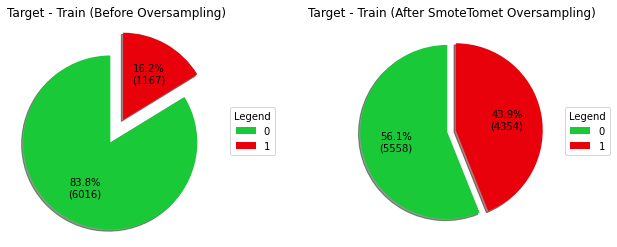

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=[11,4])

labels_1 = before_oversampling_train_target.index
data_1 = before_oversampling_train_target.values
title_1 = "Target - Train (Before Oversampling)"

labels_2 = after_oversampling_smote_train_target.index
data_2 = after_oversampling_smote_train_target.values
title_2 = "Target - Train (After SmoteTomet Oversampling)"

colors = sns.color_palette('bright')[2:4]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

wedges_1, texts_1, autopcts_1 = ax1.pie(x= data_1, 
                                         autopct=lambda pct: func(pct, data_1), 
                                         explode=[0.15]*len(data_1), 
                                         shadow=True, 
                                         startangle = 90,
                                         colors = colors
                                         )

wedges_2, texts_2, autopcts_2 = ax2.pie(x= data_2, 
                                         autopct=lambda pct: func(pct, data_2), 
                                         explode=[0.05]*len(data_2), 
                                         shadow=True, 
                                         startangle = 90,
                                         colors = colors
                                         )

# Adding legend
ax1.legend(wedges_1, labels_1,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

ax2.legend(wedges_2, labels_2,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':9})

ax1.set_title(title_1, fontsize=12)
ax2.set_title(title_2, fontsize=12)
plt.show()
#fig.suptitle('Distributions', fontsize=14, fontweight="bold");

<div style="font-size: 16px;color:blue"> <b>Analysis Summary: </b></div><br/>

<div  style="font-size:15px;color:blue">
- The target column 'not.fully.paid' was moved at the end. <br/>
- Because the target column is imbalanced, the dataset was balanced using <b>'Random Oversampling'</b> and <b>'Smotetomek Oversampling'</b> techniques.<br/>
</div>

#### Sacling the dataset features

In [59]:
scaler = MinMaxScaler()

X_train_original = scaler.fit_transform(X_train)
X_test_original = scaler.transform(X_test)

In [60]:
scaler_random_oversampling = MinMaxScaler()

X_train_oversampled = scaler_random_oversampling.fit_transform(X_train_oversampled)

In [61]:
scaler_smote_oversampling = MinMaxScaler()

X_train_oversampled_smote = scaler_smote_oversampling.fit_transform(X_train_oversampled_smote)

In [62]:
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
y_train_oversampled = y_train_oversampled.astype('int64')
y_train_oversampled_smote = y_train_oversampled_smote.astype('int64')

#### Building the ANN Model - using 'RandomOversampled Data'

In [63]:
# Initialising the ANN 
classifier_random_oversampled = Sequential()

# Adding the input layer and the first hidden layer
classifier_random_oversampled.add(Dense(8, kernel_initializer = 'he_uniform',activation='relu',input_dim = 16))

# Adding the second hidden layer
classifier_random_oversampled.add(Dense(4, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the third hidden layer
#classifier_random_oversampled.add(Dense(4, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the output layer
classifier_random_oversampled.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier_random_oversampled.compile(optimizer = 'Adamax', 
                                      loss = 'binary_crossentropy', 
                                      metrics = ['accuracy', tf.keras.metrics.Recall(thresholds=0)])

In [64]:
# Fitting the ANN to the Training set
model_history_original = classifier_random_oversampled.fit(x = X_train_oversampled, 
                                                             y = y_train_oversampled, 
                                                             validation_split=0.20, 
                                                             batch_size = 2000, 
                                                             epochs = 300)

Epoch 1/300
5/5 [==============================] - 1s 74ms/step - loss: 0.6722 - accuracy: 0.6570 - recall: 1.0000 - val_loss: 0.7968 - val_accuracy: 0.0457 - val_recall: 1.0000
Epoch 2/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6650 - accuracy: 0.6671 - recall: 1.0000 - val_loss: 0.8201 - val_accuracy: 0.0309 - val_recall: 1.0000
Epoch 3/300
5/5 [==============================] - 0s 10ms/step - loss: 0.6585 - accuracy: 0.6742 - recall: 1.0000 - val_loss: 0.8434 - val_accuracy: 0.0185 - val_recall: 1.0000
Epoch 4/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6524 - accuracy: 0.6781 - recall: 1.0000 - val_loss: 0.8665 - val_accuracy: 0.0092 - val_recall: 1.0000
Epoch 5/300
5/5 [==============================] - 0s 7ms/step - loss: 0.6469 - accuracy: 0.6821 - recall: 1.0000 - val_loss: 0.8893 - val_accuracy: 0.0055 - val_recall: 1.0000
Epoch 6/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6419 - accuracy: 0.6861 - recall: 1.0000

In [65]:
# viewing the losses, accuracy and recall metrics

losses_random = pd.DataFrame(classifier_random_oversampled.history.history)
losses_random.head()

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
0,0.672240,0.657008,1.0,0.796784,0.045706,1.0
1,0.665000,0.667051,1.0,0.820053,0.030933,1.0
2,0.658480,0.674209,1.0,0.843429,0.018467,1.0
3,0.652399,0.678134,1.0,0.866455,0.009234,1.0
4,0.646892,0.682060,1.0,0.889337,0.005540,1.0


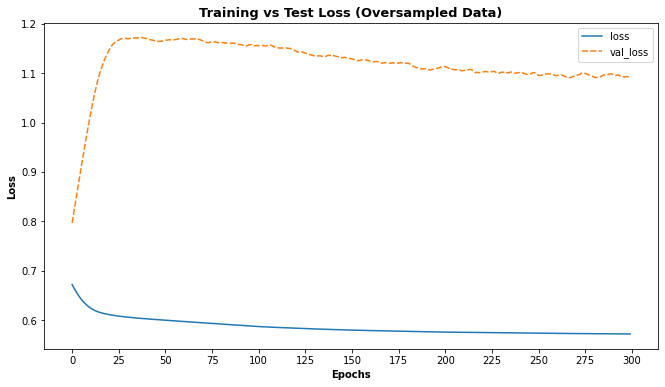

In [66]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_random[['loss', 'val_loss']])
plt.title('Training vs Test Loss (Oversampled Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Loss', fontweight="bold")

plt.xticks(range(0, 301, 25))

plt.show()

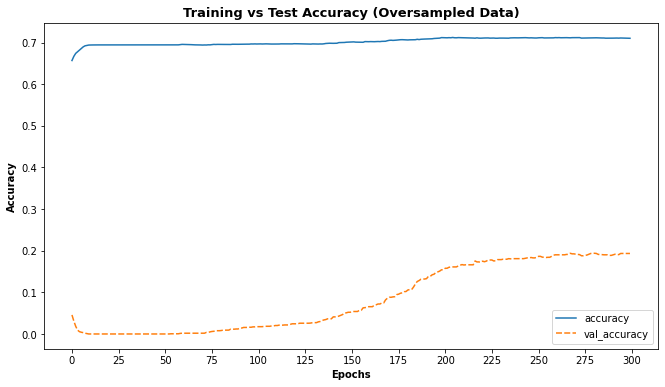

In [67]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_random[['accuracy', 'val_accuracy']])
plt.title('Training vs Test Accuracy (Oversampled Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Accuracy', fontweight="bold")

plt.xticks(range(0, 301, 25))

plt.show()

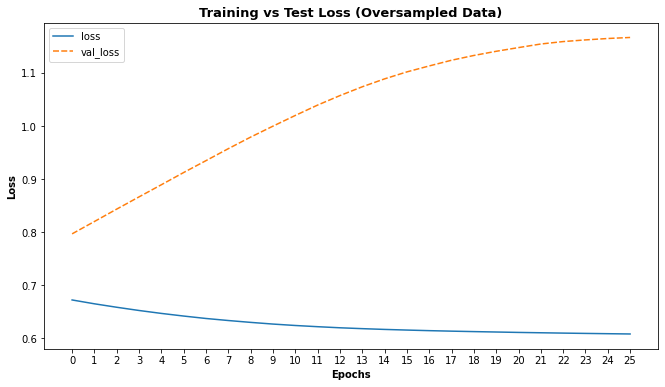

In [68]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_random[['loss', 'val_loss']].iloc[:26, :])
plt.title('Training vs Test Loss (Oversampled Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Loss', fontweight="bold")

plt.xticks(range(0, 26, 1))

plt.show()

In [69]:
losses_random.iloc[6:7,:]

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
6,0.637338,0.689794,1.0,0.934742,0.003232,1.0


In [70]:
classifier_random_oversampled = Sequential()


classifier_random_oversampled.add(Dense(8, kernel_initializer = 'he_uniform',activation='relu',input_dim = 16))
classifier_random_oversampled.add(Dense(4, kernel_initializer = 'he_uniform',activation='relu'))
classifier_random_oversampled.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

classifier_random_oversampled.compile(optimizer = 'Adamax', 
                                      loss = 'binary_crossentropy', 
                                      metrics = ['accuracy', tf.keras.metrics.Recall(thresholds=0)])

model_history_original = classifier_random_oversampled.fit(x = X_train_oversampled, 
                                                             y = y_train_oversampled, 
                                                             validation_split=0.20, 
                                                             batch_size = 2000, 
                                                             epochs = 6, verbose=0)

In [71]:
y_pred_train = classifier_random_oversampled.predict(X_train_oversampled)
y_pred_train = np.where(y_pred_train > 0.40, 1,0)


y_pred_test = classifier_random_oversampled.predict(X_test_original)
y_pred_test = np.where(y_pred_test > 0.40, 1,0)

In [72]:
np.unique(y_pred_train, return_counts=True)

(array([0, 1]), array([1018, 9810]))

In [73]:
np.unique(y_pred_test, return_counts=True)

(array([0, 1]), array([ 234, 2161]))



************************** Confusion Matrix (Training Data) **************************




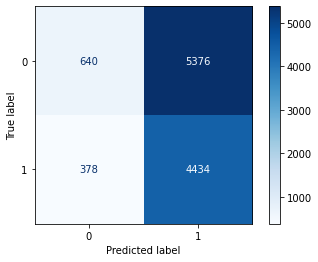

In [74]:
print("\n\n************************** Confusion Matrix (Training Data) **************************\n\n")

cm = confusion_matrix(y_train_oversampled, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='')
plt.show()


In [75]:
print("\n\n************************** Classification Report (Train Data) **************************\n\n")
print(classification_report(y_train_oversampled, y_pred_train))



************************** Classification Report (Train Data) **************************


              precision    recall  f1-score   support

           0       0.63      0.11      0.18      6016
           1       0.45      0.92      0.61      4812

    accuracy                           0.47     10828
   macro avg       0.54      0.51      0.39     10828
weighted avg       0.55      0.47      0.37     10828





************************** Confusion Matrix (Test Data) **************************



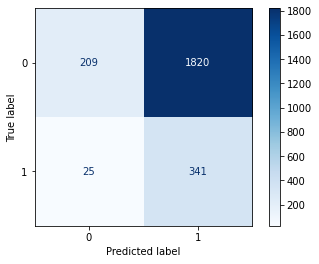

In [76]:
print("\n\n************************** Confusion Matrix (Test Data) **************************\n")

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='')
plt.show()

In [77]:
print("\n\n************************** Classification Report (Test Data) **************************\n\n")
print(classification_report(y_test, y_pred_test))



************************** Classification Report (Test Data) **************************


              precision    recall  f1-score   support

           0       0.89      0.10      0.18      2029
           1       0.16      0.93      0.27       366

    accuracy                           0.23      2395
   macro avg       0.53      0.52      0.23      2395
weighted avg       0.78      0.23      0.20      2395



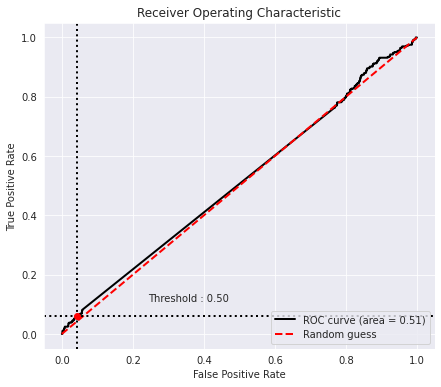

In [78]:
# plotting ROC Curve

# Getting predicted probabilites values, for plotting of ROC curve
test_pred_probs = classifier_random_oversampled.predict(X_test_original)

# Visualisation with plot_metric
bc = BinaryClassification(y_test, test_pred_probs, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(7,6))
bc.plot_roc_curve()
plt.show()

<div style="font-size: 16px;color:blue"> <b>Analysis Summary: </b></div><br/>

<div  style="font-size:15px;color:blue">
- ANN Model was build using the 'Random Oversampled' data. <br/>
- The model has two layers with 8 and 4 densly connected nodes respectively. The model was run for 300 epochs having batch size of 2000 with validation split as 20%.<br/>
- The model did not perform well, the losses of training set and test set were parallel almost, without any intersection. <br/>
- The model at 06th epoch was evaluated and obtained accuracy of 23%, with 0.51 as the value for area under the ROC curve.<br/>
</div>

####  Building the ANN Model - using 'SmoteTomek Oversampled Data'

In [79]:
# Initialising the ANN 
classifier_random_oversampled_smote = Sequential()

# Adding the input layer and the first hidden layer
classifier_random_oversampled_smote.add(Dense(8, kernel_initializer = 'he_uniform',activation='relu',input_dim = 16))

# Adding the second hidden layer
classifier_random_oversampled_smote.add(Dense(4, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the output layer
classifier_random_oversampled_smote.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier_random_oversampled_smote.compile(optimizer = 'Adam', 
                                      loss = 'binary_crossentropy', 
                                      metrics = ['accuracy', tf.keras.metrics.Recall(thresholds=0)])

In [80]:
# Fitting the ANN to the Training set
model_history_original = classifier_random_oversampled_smote.fit(x = X_train_oversampled_smote, 
                                                             y = y_train_oversampled_smote, 
                                                             validation_split=0.20, 
                                                             batch_size = 2000, 
                                                             epochs = 300)

Epoch 1/300
4/4 [==============================] - 1s 76ms/step - loss: 0.6916 - accuracy: 0.6887 - recall_2: 1.0000 - val_loss: 0.6954 - val_accuracy: 0.0287 - val_recall_2: 1.0000
Epoch 2/300
4/4 [==============================] - 0s 11ms/step - loss: 0.6898 - accuracy: 0.6924 - recall_2: 1.0000 - val_loss: 0.6985 - val_accuracy: 0.0192 - val_recall_2: 1.0000
Epoch 3/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6879 - accuracy: 0.6945 - recall_2: 1.0000 - val_loss: 0.7016 - val_accuracy: 0.0126 - val_recall_2: 1.0000
Epoch 4/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6860 - accuracy: 0.6963 - recall_2: 1.0000 - val_loss: 0.7051 - val_accuracy: 0.0091 - val_recall_2: 1.0000
Epoch 5/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6837 - accuracy: 0.6968 - recall_2: 1.0000 - val_loss: 0.7089 - val_accuracy: 0.0045 - val_recall_2: 1.0000
Epoch 6/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6813 - accuracy: 0.6

In [81]:
losses_smote = pd.DataFrame(classifier_random_oversampled_smote.history.history)
losses_smote.head()

,loss,accuracy,recall_2,val_loss,val_accuracy,val_recall_2
0,0.691563,0.688738,1.0,0.695435,0.028744,1.0
1,0.689799,0.692395,1.0,0.698453,0.019163,1.0
2,0.687936,0.694539,1.0,0.701624,0.012607,1.0
3,0.685951,0.696305,1.0,0.705062,0.009077,1.0
4,0.683735,0.696809,1.0,0.708934,0.004539,1.0


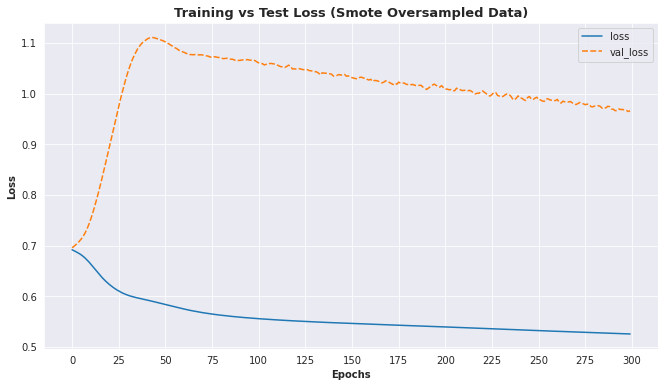

In [82]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_smote[['loss', 'val_loss']])
plt.title('Training vs Test Loss (Smote Oversampled Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Loss', fontweight="bold")

plt.xticks(range(0, 301, 25))

plt.show()

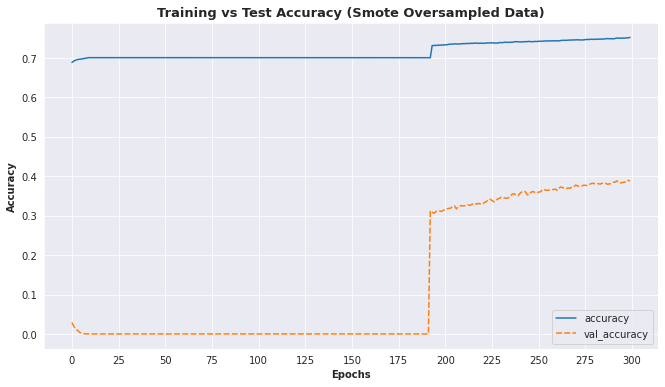

In [83]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_smote[['accuracy', 'val_accuracy']])
plt.title('Training vs Test Accuracy (Smote Oversampled Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Accuracy', fontweight="bold")

plt.xticks(range(0, 301, 25))

plt.show()

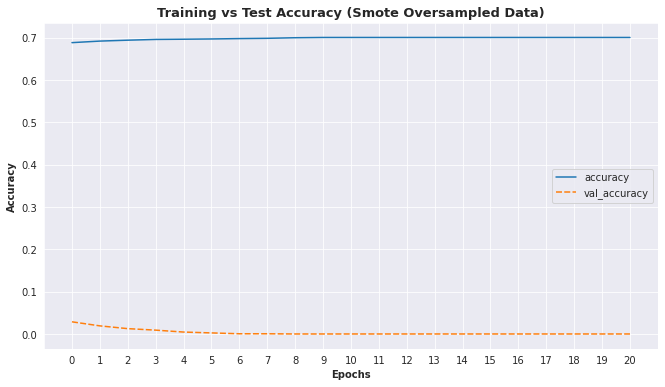

In [84]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_smote[['accuracy', 'val_accuracy']].iloc[:21])
plt.title('Training vs Test Accuracy (Smote Oversampled Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Accuracy', fontweight="bold")

plt.xticks(range(0, 21, 1))

plt.show()

In [85]:
losses_smote.iloc[3:4,:]

,loss,accuracy,recall_2,val_loss,val_accuracy,val_recall_2
3,0.685951,0.696305,1.0,0.705062,0.009077,1.0


In [86]:

classifier_random_oversampled_smote = Sequential()

classifier_random_oversampled_smote.add(Dense(8, kernel_initializer = 'he_uniform',activation='relu',input_dim = 16))
classifier_random_oversampled_smote.add(Dense(4, kernel_initializer = 'he_uniform',activation='relu'))
classifier_random_oversampled_smote.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

classifier_random_oversampled_smote.compile(optimizer = 'Adam', 
                                      loss = 'binary_crossentropy', 
                                      metrics = ['accuracy', tf.keras.metrics.Recall(thresholds=0)])

model_history_original = classifier_random_oversampled_smote.fit(x = X_train_oversampled_smote, 
                                                             y = y_train_oversampled_smote, 
                                                             validation_split=0.20, 
                                                             batch_size = 2000, 
                                                             epochs = 3, verbose = 0)

In [87]:
y_pred_train = classifier_random_oversampled_smote.predict(X_train_oversampled_smote)
y_pred_train = np.where(y_pred_train > 0.40, 1,0)


y_pred_test = classifier_random_oversampled_smote.predict(X_test_original)
y_pred_test = np.where(y_pred_test > 0.40, 1,0)

In [88]:
np.unique(y_pred_train, return_counts=True)

(array([0, 1]), array([ 170, 9742]))

In [89]:
np.unique(y_pred_test, return_counts=True)

(array([0, 1]), array([  58, 2337]))



************************** Confusion Matrix (Training Data) **************************




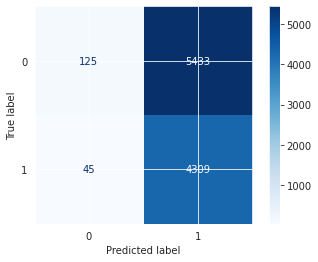

In [90]:
print("\n\n************************** Confusion Matrix (Training Data) **************************\n\n")

cm = confusion_matrix(y_train_oversampled_smote, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='')
plt.show()


In [91]:
print("\n\n************************** Classification Report (Train Data) **************************\n\n")
print(classification_report(y_train_oversampled_smote, y_pred_train))



************************** Classification Report (Train Data) **************************


              precision    recall  f1-score   support

           0       0.74      0.02      0.04      5558
           1       0.44      0.99      0.61      4354

    accuracy                           0.45      9912
   macro avg       0.59      0.51      0.33      9912
weighted avg       0.61      0.45      0.29      9912





************************** Confusion Matrix (Test Data) **************************



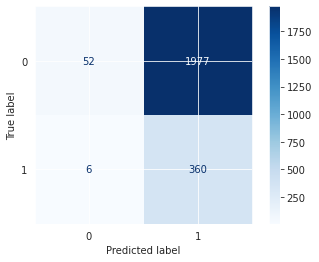

In [92]:
print("\n\n************************** Confusion Matrix (Test Data) **************************\n")

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='')
plt.show()

In [93]:
print("\n\n************************** Classification Report (Test Data) **************************\n\n")
print(classification_report(y_test, y_pred_test))



************************** Classification Report (Test Data) **************************


              precision    recall  f1-score   support

           0       0.90      0.03      0.05      2029
           1       0.15      0.98      0.27       366

    accuracy                           0.17      2395
   macro avg       0.53      0.50      0.16      2395
weighted avg       0.78      0.17      0.08      2395



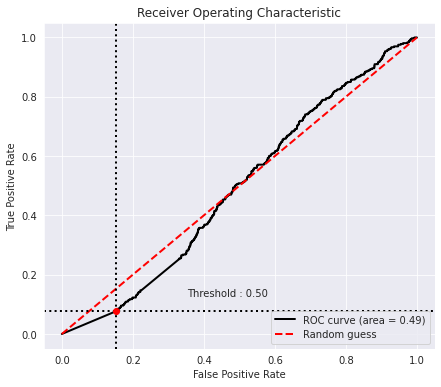

In [94]:
# plotting ROC Curve

# Getting predicted probabilites values, for plotting of ROC curve
test_pred_probs = classifier_random_oversampled_smote.predict(X_test_original)

# Visualisation with plot_metric
bc = BinaryClassification(y_test, test_pred_probs, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(7,6))
bc.plot_roc_curve()
plt.show()

<div style="font-size: 16px;color:blue"> <b>Analysis Summary: </b></div><br/>

<div  style="font-size:15px;color:blue">
- ANN Model was build using the 'Smote Tomek Oversampled' data. <br/>
- The model has two layers with 8 and 4 densly connected nodes respectively. The model was run for 300 epochs having batch size of 2000 with validation split as 20%. <br/>
- The model did not perform well either using Smote Tomek oversampling technique, the losses of training set and test set were parallel almost, except that they converged at the begining and drifted apart throughout, without any intersection. <br/>
- The model at 03rd epoch was evaluated and obtained accuracy of 17%, with 0.49 as the value for area under the ROC curve. Poorer then random oversampled data.<br/>
</div>

####  Building the ANN Model - using original data (without any oversampling or balancing of target)

In [95]:
# Initialising the ANN
classifier_original = Sequential()

# Adding the input layer and the first hidden layer
classifier_original.add(Dense(16, kernel_initializer = 'he_uniform',activation='relu',input_dim = 16))

# Adding the second hidden layer
classifier_original.add(Dense(8, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the output layer
classifier_original.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier_original.compile(optimizer = 'Adam', 
                                      loss = 'binary_crossentropy', 
                                      metrics = ['accuracy', tf.keras.metrics.Recall(thresholds=0)])

In [96]:
# Fitting the ANN to the Training set
model_history_original = classifier_original.fit(x = X_train_original, 
                                                 y = y_train, 
                                                 validation_split=0.20, 
                                                 batch_size = 1000, 
                                                 epochs = 300)

Epoch 1/300
6/6 [==============================] - 1s 48ms/step - loss: 0.9735 - accuracy: 0.1631 - recall_4: 1.0000 - val_loss: 0.9426 - val_accuracy: 0.1649 - val_recall_4: 1.0000
Epoch 2/300
6/6 [==============================] - 0s 6ms/step - loss: 0.9187 - accuracy: 0.1639 - recall_4: 1.0000 - val_loss: 0.8912 - val_accuracy: 0.1642 - val_recall_4: 1.0000
Epoch 3/300
6/6 [==============================] - 0s 7ms/step - loss: 0.8697 - accuracy: 0.1666 - recall_4: 1.0000 - val_loss: 0.8437 - val_accuracy: 0.1705 - val_recall_4: 1.0000
Epoch 4/300
6/6 [==============================] - 0s 6ms/step - loss: 0.8231 - accuracy: 0.1796 - recall_4: 1.0000 - val_loss: 0.7974 - val_accuracy: 0.1893 - val_recall_4: 1.0000
Epoch 5/300
6/6 [==============================] - 0s 11ms/step - loss: 0.7785 - accuracy: 0.2360 - recall_4: 1.0000 - val_loss: 0.7550 - val_accuracy: 0.3048 - val_recall_4: 1.0000
Epoch 6/300
6/6 [==============================] - 0s 8ms/step - loss: 0.7381 - accuracy: 0.4

In [97]:
losses_original = pd.DataFrame(classifier_original.history.history)
losses_original.head()

,loss,accuracy,recall_4,val_loss,val_accuracy,val_recall_4
0,0.973469,0.163070,1.0,0.942567,0.164927,1.0
1,0.918706,0.163940,1.0,0.891225,0.164231,1.0
2,0.869729,0.166551,1.0,0.843651,0.170494,1.0
3,0.823137,0.179603,1.0,0.797393,0.189283,1.0
4,0.778473,0.235990,1.0,0.754952,0.304802,1.0


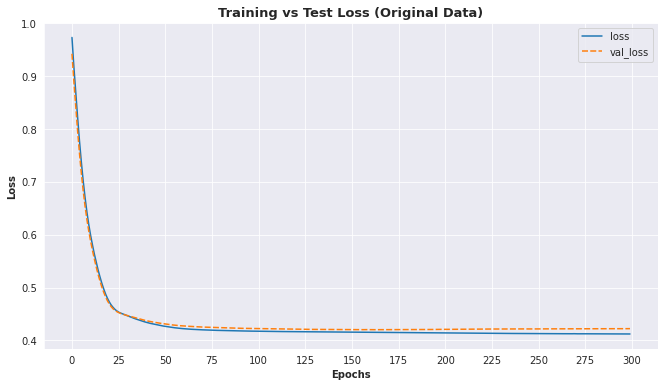

In [98]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_original[['loss', 'val_loss']])
plt.title('Training vs Test Loss (Original Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Loss', fontweight="bold")

plt.xticks(range(0, 301, 25))

plt.show()


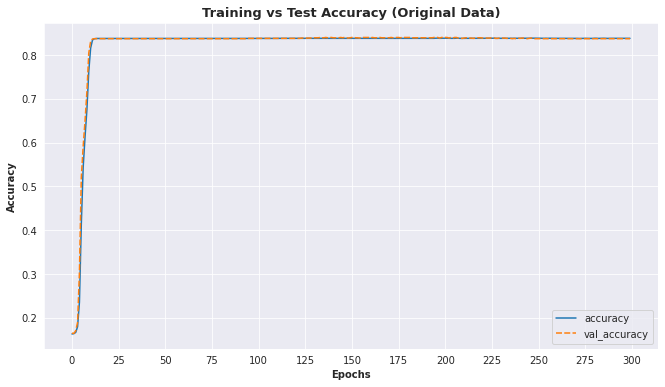

In [99]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_original[['accuracy', 'val_accuracy']])
plt.title('Training vs Test Accuracy (Original Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Accuracy', fontweight="bold")

plt.xticks(range(0, 301, 25))

plt.show()

In [100]:
losses_original.iloc[50:51,:]

,loss,accuracy,recall_4,val_loss,val_accuracy,val_recall_4
50,0.426442,0.837626,1.0,0.430933,0.837161,1.0


In [101]:
classifier_original = Sequential()

classifier_original.add(Dense(16, kernel_initializer = 'he_uniform',activation='relu',input_dim = 16))
classifier_original.add(Dense(8, kernel_initializer = 'he_uniform',activation='relu'))
classifier_original.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))


classifier_original.compile(optimizer = 'Adam', 
                                      loss = 'binary_crossentropy', 
                                      metrics = ['accuracy', tf.keras.metrics.Recall(thresholds=0)])


model_history_original = classifier_original.fit(x = X_train_original, 
                                                 y = y_train, 
                                                 validation_split=0.20, 
                                                 batch_size = 1000, 
                                                 epochs = 50, verbose=0)

In [102]:
y_pred_train = classifier_original.predict(X_train_original)
y_pred_train = np.where(y_pred_train > 0.40, 1,0)


y_pred_test = classifier_original.predict(X_test_original)
y_pred_test = np.where(y_pred_test > 0.40, 1,0)

In [103]:
np.unique(y_pred_train, return_counts=True)

(array([0, 1]), array([7045,  138]))

In [104]:
np.unique(y_pred_test, return_counts=True)

(array([0, 1]), array([2341,   54]))



************************** Confusion Matrix (Training Data) **************************




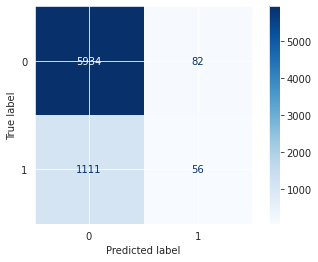

In [105]:
print("\n\n************************** Confusion Matrix (Training Data) **************************\n\n")

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='')
plt.show()


In [106]:
print("\n\n************************** Classification Report (Train Data) **************************\n\n")
print(classification_report(y_train, y_pred_train))



************************** Classification Report (Train Data) **************************


              precision    recall  f1-score   support

           0       0.84      0.99      0.91      6016
           1       0.41      0.05      0.09      1167

    accuracy                           0.83      7183
   macro avg       0.62      0.52      0.50      7183
weighted avg       0.77      0.83      0.77      7183





************************** Confusion Matrix (Test Data) **************************



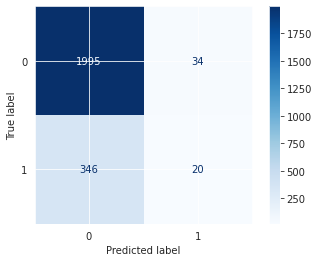

In [107]:
print("\n\n************************** Confusion Matrix (Test Data) **************************\n")

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='')
plt.show()

In [108]:
print("\n\n************************** Classification Report (Test Data) **************************\n\n")
print(classification_report(y_test, y_pred_test))



************************** Classification Report (Test Data) **************************


              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2029
           1       0.37      0.05      0.10       366

    accuracy                           0.84      2395
   macro avg       0.61      0.52      0.50      2395
weighted avg       0.78      0.84      0.79      2395



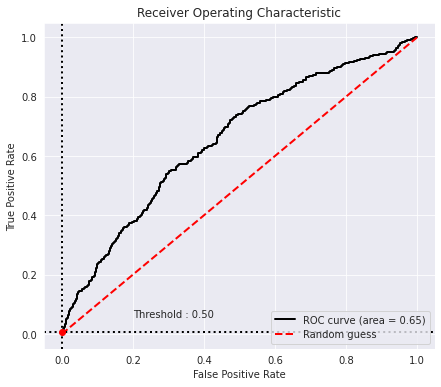

In [109]:
# plotting ROC Curve

# Getting predicted probabilites values, for plotting of ROC curve
test_pred_probs = classifier_original.predict(X_test_original)

# Visualisation with plot_metric
bc = BinaryClassification(y_test, test_pred_probs, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(7,6))
bc.plot_roc_curve()
plt.show()

<div style="font-size: 16px;color:blue"> <b>Analysis Summary: </b></div><br/>

<div  style="font-size:15px;color:blue">
- Finally, I dropped the idea of oversampling and thought of using the original data as is, for ANN model building. </br>
- The model build has two layers with 16 and 8 densly connected nodes respectively. The model was run for 300 epochs having batch size of 1000 with validation split as 20%. </br>
- The model performed extremely well, compared to the models from oversampled data. </br>
- The model loss curve was as per the expectations, both decreased alongside. The accuracy curve was also similar for training and testing data. </br>
- The model at 50th epoch was evaluated and obtained outstanding validation accuracy of 84%, with 0.05 as the recall value for minority class (1). </br>
- The value for area under the ROC curve was found to be 0.65. Better then the random guess. </br>
</div>

#### Hyper-parameter tuning using 'keras_tuner'

- Original 'training' dataset is: X_train_original, y_train
- Original 'test' dataset is: X_test_original, y_test

In [123]:
def model_builder(hp):
    
    model = Sequential()
    model.add(InputLayer((16,)))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units1 = hp.Int('units1', min_value=4, max_value=64, step=4)
    hp_units2 = hp.Int('units2', min_value=4, max_value=64, step=4)
    
    model.add(Dense(units=hp_units1, kernel_initializer = 'he_uniform', activation='relu'))
    model.add(Dense(units=hp_units2, kernel_initializer = 'he_uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    
    model.compile(tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy', tf.keras.metrics.Recall(thresholds=0)])
    
    return model

In [124]:
tuner = kt.Hyperband(
    model_builder,
    objective='accuracy',
    max_epochs=100,
    directory='keras_tuner_dir',
    project_name='Lending Club Loan Analysis'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [125]:
tuner.search(X_train_original, y_train, epochs=150, validation_split=0.2, callbacks=[stop_early])

Trial 254 Complete [00h 00m 08s]
accuracy: 0.8386703729629517

Best accuracy So Far: 0.8405847549438477
Total elapsed time: 00h 14m 57s
INFO:tensorflow:Oracle triggered exit


In [131]:
# Get the optimal hyperparameters
# best_hps= tuner.get_best_hyperparameters()[0]

for h_param in [f"units{i}" for i in range(1,3)] + ['learning_rate']:
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 60
units2 16
learning_rate 0.001


In [132]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_original.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                1020      
                                                                 
 dense_1 (Dense)             (None, 16)                976       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,013
Trainable params: 2,013
Non-trainable params: 0
_________________________________________________________________


In [133]:
classifier_original.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                272       
                                                                 
 dense_16 (Dense)            (None, 8)                 136       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


In [134]:
best_model.fit(
    X_train_original, 
    y_train,
    epochs=15,
    batch_size=1000
)

Epoch 1/15
8/8 [==============================] - 1s 2ms/step - loss: 0.4091 - accuracy: 0.8386 - recall: 1.0000
Epoch 2/15
8/8 [==============================] - 0s 3ms/step - loss: 0.4088 - accuracy: 0.8388 - recall: 1.0000
Epoch 3/15
8/8 [==============================] - 0s 4ms/step - loss: 0.4087 - accuracy: 0.8389 - recall: 1.0000
Epoch 4/15
8/8 [==============================] - 0s 3ms/step - loss: 0.4083 - accuracy: 0.8389 - recall: 1.0000
Epoch 5/15
8/8 [==============================] - 0s 3ms/step - loss: 0.4081 - accuracy: 0.8389 - recall: 1.0000
Epoch 6/15
8/8 [==============================] - 0s 3ms/step - loss: 0.4081 - accuracy: 0.8391 - recall: 1.0000
Epoch 7/15
8/8 [==============================] - 0s 3ms/step - loss: 0.4079 - accuracy: 0.8389 - recall: 1.0000
Epoch 8/15
8/8 [==============================] - 0s 3ms/step - loss: 0.4078 - accuracy: 0.8391 - recall: 1.0000
Epoch 9/15
8/8 [==============================] - 0s 5ms/step - loss: 0.4079 - accuracy: 0.8388 

In [135]:
y_pred_train = best_model.predict(X_train_original)
y_pred_train = np.where(y_pred_train > 0.40, 1,0)


y_pred_test = best_model.predict(X_test_original)
y_pred_test = np.where(y_pred_test > 0.40, 1,0)

In [136]:
np.unique(y_pred_train, return_counts=True)

(array([0, 1]), array([6964,  219]))

In [137]:
np.unique(y_pred_test, return_counts=True)

(array([0, 1]), array([2316,   79]))



************************** Confusion Matrix (Training Data) **************************




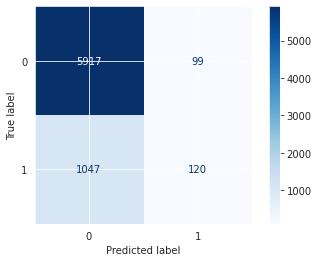

In [138]:
print("\n\n************************** Confusion Matrix (Training Data) **************************\n\n")

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='')
plt.show()


In [139]:
print("\n\n************************** Classification Report (Train Data) **************************\n\n")
print(classification_report(y_train, y_pred_train))



************************** Classification Report (Train Data) **************************


              precision    recall  f1-score   support

           0       0.85      0.98      0.91      6016
           1       0.55      0.10      0.17      1167

    accuracy                           0.84      7183
   macro avg       0.70      0.54      0.54      7183
weighted avg       0.80      0.84      0.79      7183





************************** Confusion Matrix (Test Data) **************************



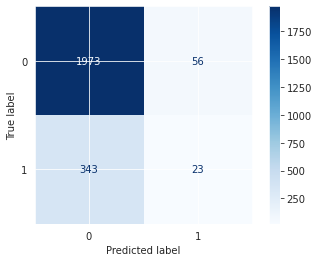

In [140]:
print("\n\n************************** Confusion Matrix (Test Data) **************************\n")

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='')
plt.show()

In [141]:
print("\n\n************************** Classification Report (Test Data) **************************\n\n")
print(classification_report(y_test, y_pred_test))



************************** Classification Report (Test Data) **************************


              precision    recall  f1-score   support

           0       0.85      0.97      0.91      2029
           1       0.29      0.06      0.10       366

    accuracy                           0.83      2395
   macro avg       0.57      0.52      0.51      2395
weighted avg       0.77      0.83      0.79      2395



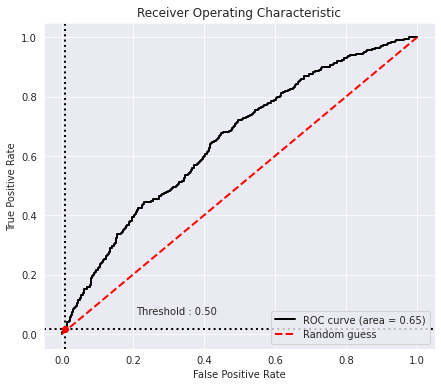

In [142]:
# plotting ROC Curve

# Getting predicted probabilites values, for plotting of ROC curve
test_pred_probs = best_model.predict(X_test_original)

# Visualisation with plot_metric
bc = BinaryClassification(y_test, test_pred_probs, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(7,6))
bc.plot_roc_curve()
plt.show()

<div style="font-size: 16px;color:blue"> <b>Analysis Summary: </b></div><br/>

<div  style="font-size:15px;color:blue">
- I though that maybe we can get a better model using hyperparameter tuning (via keras_tuner). </br>
- Tried to get optimum values for two layer model, minimum range used is 4 nodes and maximum used is 64 nodes, with the step size of 4. </br>
- However, the best model obtained had values of 60 and 16 nodes in first and second layer respectively, still the accuracy was almost same. about 84%. </br>
- Best model obtained was evaluated but had same values for validation accuracy, and lesser values for recall for minority class. Area under ROC curve is same as that of the model I built using original dataset, 0.65</br>
- Therefore, the model I had created using the original data (with no oversampling) is the best of all I tried so far. The accuracy couldn't be increased even after hyperparameter tuning indicates that the data features are either low or the data is insufficient for the model to learn. </br>
</div>

<center> <h3> End of the Project </h3> </center>